# Slow close-up

Although our playback speed is slow already (0.01X), the bouncing event still looks very fast. To be able to see the bouncing very clearly, it is desired that we do a slow close-up at the bouncing event, where fps is dramatically increased and the camera is moved close to the bubble.

In this notebook, we implement the functions necessary for this purpose. 

## 0 Packages

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks
plt.rcParams['ytick.major.size'] = 2  # Length of major ticks
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks
import time

## 1 Slow motion

We used to do the video at a constant speed (fps). In the improved version, we want to have denser frames near the bounce, so in the output video, we can see the boucning event in a slower motion. The fps as a function of time would look like a flat line with a sharp peak around the corner. 

For example, if we have a 50 ms video, and the bouncing happens around 16 ms, we would have a base fps at 0 ms and 50 ms, and a peak fps at 16 ms.

The simplest implementation of fps vs. t would look like

Text(0, 0.5, 'FPS')

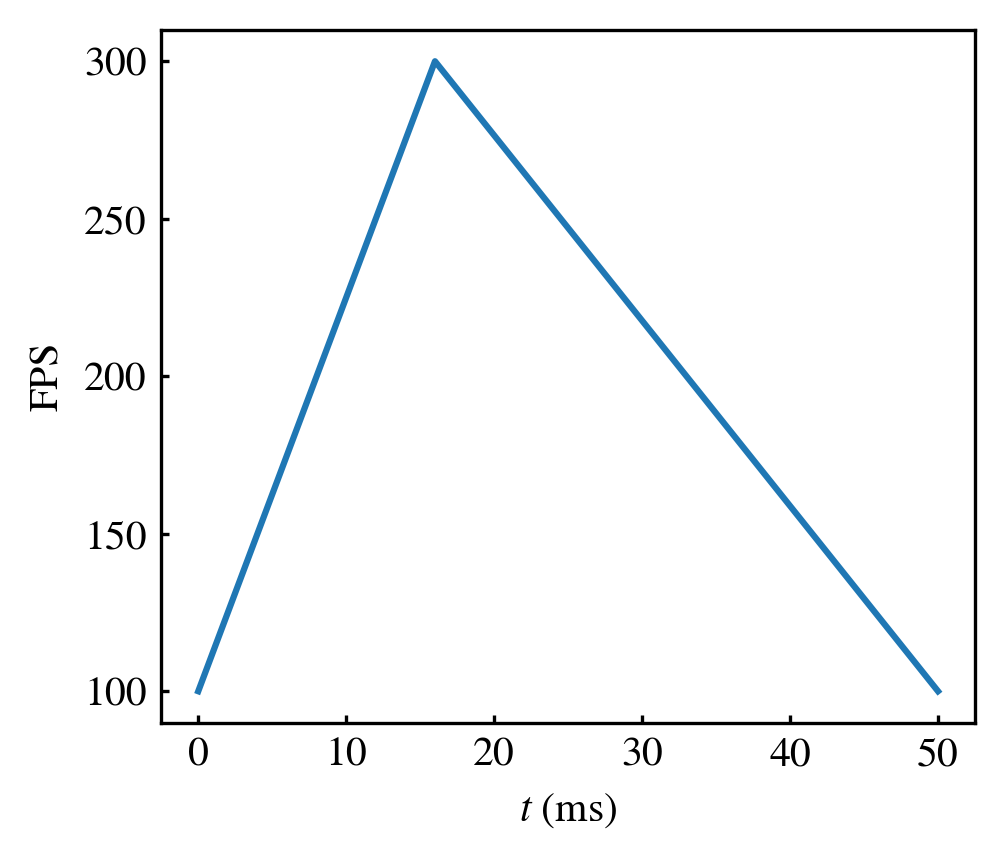

In [6]:
t = [0, 16, 50]
fps = [100, 300, 100]
plt.figure(figsize=(3.5, 3), dpi=300)
plt.plot(t, fps)
plt.xlabel("$t$ (ms)")
plt.ylabel("FPS")

Using the FPS(t) function, we can generate a time "mesh". First, we need to write FPS(t) into an actual function, where we have access to values at all times. 

In [7]:
t_start = 0
t_peak = 16
t_end = 50
low, high = 100, 300
def fps_func(t):
    if t < t_peak:
        return low + (high - low) / (t_peak - t_start) * (t - t_start) 
    elif t < t_end:
        return high - (high - low) / (t_end - t_peak) * (t - t_peak)
    else:
        return low

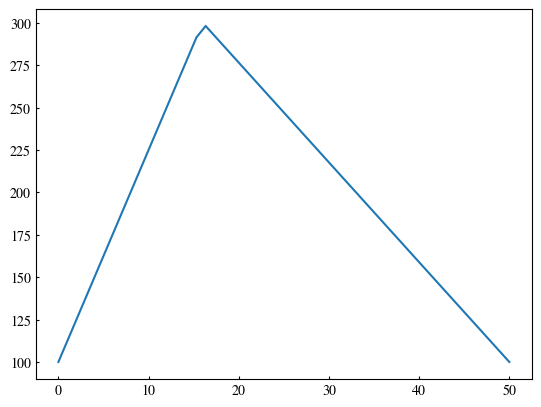

In [13]:
t = np.linspace(0, 50)
fps = list(map(fps_func, t))
plt.plot(t, fps)

We can now generate the time mesh. 

In [ ]:
t = t_start
t_mesh = [t]
while t < t_end:
    interval = 1 / (fps_func(t) / 0.01)
    t += interval
    t_mesh.append(t)
t_mesh = np.array(t_mesh)

(np.float64(-2.5011489224482917),
 np.float64(52.524127371414124),
 np.float64(-0.05500000000000001),
 np.float64(0.05500000000000001))

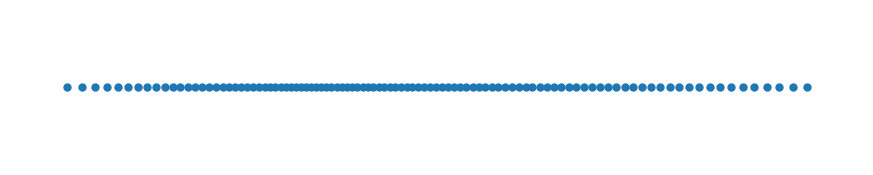

In [28]:
plt.figure(figsize=(3.5, 0.5), dpi=300)
plt.scatter(t_mesh, np.zeros_like(t_mesh), s=1)
plt.axis("off")

We can write a time mesh class to handle the mesh generation. 

In [ ]:
class TimeMesh:
    """Generate time mesh."""
    def __init__(self, start, end, fps, playback=0.01):
        self.start = start
        self.end = end
        self.fps = fps
        self.playback = playback

    def uniform(self):
        """Uniform time mesh."""

        mesh = [self.start]
        t = self.start
        while t < self.end:
            interval = 1 / self.fps * self.playback
            t += interval
            mesh.append(t)
        return np.array(mesh)
        
    def peak(self, 
             peak_time : float, 
             peak_fps : float, 
             peak_half_width : float = None):
        """Non-uniform time mesh with a peak in fps."""

        t_start = self.start if peak_half_width is None else peak_time - peak_half_width
        t_end = self.end if peak_half_width is None else peak_time + peak_half_width
        low = self.fps
        high = peak_fps
        t_peak = peak_time

        def fps_func(t):
            if t < t_start:
                return low
            if t < t_peak:
                return low + (high - low) / (t_peak - t_start) * (t - t_start) 
            elif t < t_end:
                return high - (high - low) / (t_end - t_peak) * (t - t_peak)
            else:
                return low
        
        
        mesh = [self.start]
        t = self.start
        while t < self.end:
            interval = 1 / fps_func(t) * self.playback
            t += interval
            mesh.append(t)
        return np.array(mesh)

In [11]:
tm = TimeMesh(0, 50e-3, 30, playback=0.02)
uniform = tm.uniform()
peak = tm.peak(16e-3, 100, 5e-3)

(np.float64(-0.0025175484769912534),
 np.float64(0.052868518016816315),
 np.float64(-0.0005),
 np.float64(0.0105))

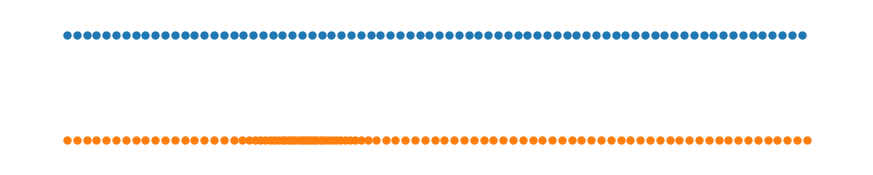

In [12]:
plt.figure(figsize=(3.5, 0.5), dpi=300)
plt.scatter(uniform, np.ones_like(uniform)*0.01, s=1)
plt.scatter(peak, np.zeros_like(peak), s=1)
plt.axis("off")